In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import os

from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, classification_report
import matplotlib.pyplot as plt

In [2]:
# X_train = np.load("./data/X_train_scaled.npy")
X_train = np.load('./data/X_train_smote.npy')
X_test = np.load("./data/X_test_scaled.npy")
# y_train = np.load("./data/y_train.npy")
y_train = np.load('./data/y_train_smote.npy')
y_test = np.load("./data/y_test.npy")

# Tensores
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

In [3]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
        pt = torch.exp(-BCE_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [4]:
class MLP(nn.Module):
    def __init__(self, input_dim):
        super(MLP, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.BatchNorm1d(64),
            nn.Dropout(0.3),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        return self.net(x).squeeze(1)

In [5]:
def train_model(model, loss_fn, optimizer, n_epochs=20):
    model.train()
    history = []
    for epoch in range(n_epochs):
        total_loss = 0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = loss_fn(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)
        history.append(avg_loss)
        print(f"Epoch {epoch+1}/{n_epochs} - Loss: {avg_loss:.4f}")
    return history

In [6]:
input_dim = X_train.shape[1]
model = MLP(input_dim)

loss_fn = FocalLoss(alpha=0.25, gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

history = train_model(model, loss_fn, optimizer, n_epochs=20)

# Mas perdida por que detecta mas casos en el proceso de entramiento debido al smote

Epoch 1/20 - Loss: 0.0217
Epoch 2/20 - Loss: 0.0185
Epoch 3/20 - Loss: 0.0173
Epoch 4/20 - Loss: 0.0165
Epoch 5/20 - Loss: 0.0158
Epoch 6/20 - Loss: 0.0152
Epoch 7/20 - Loss: 0.0146
Epoch 8/20 - Loss: 0.0142
Epoch 9/20 - Loss: 0.0139
Epoch 10/20 - Loss: 0.0136
Epoch 11/20 - Loss: 0.0135
Epoch 12/20 - Loss: 0.0134
Epoch 13/20 - Loss: 0.0132
Epoch 14/20 - Loss: 0.0131
Epoch 15/20 - Loss: 0.0130
Epoch 16/20 - Loss: 0.0129
Epoch 17/20 - Loss: 0.0131
Epoch 18/20 - Loss: 0.0128
Epoch 19/20 - Loss: 0.0127
Epoch 20/20 - Loss: 0.0126


In [7]:
model.eval()
with torch.no_grad():
    y_pred_logits = model(X_test_tensor)
    y_pred = torch.sigmoid(y_pred_logits).numpy()
    threshold = 0.7 # Changed to [0.5 -> 0.7]
    y_pred_labels = (y_pred >= threshold).astype(int)

print(classification_report(y_test, y_pred_labels, digits=4))
print("AUC:", roc_auc_score(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.9892    0.9997    0.9944    239020
           1     0.3839    0.0162    0.0311      2652

    accuracy                         0.9889    241672
   macro avg     0.6866    0.5080    0.5128    241672
weighted avg     0.9826    0.9889    0.9839    241672

AUC: 0.8514691226606179


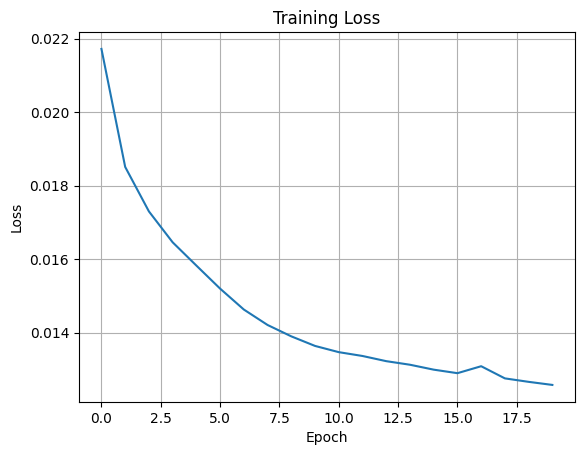

In [8]:
plt.plot(history)
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [9]:
os.makedirs("./models", exist_ok=True)
torch.save(model.state_dict(), "./models/mlp_model.pth")